Gamma Ray Image Cleanig

In [1]:
import importlib
import helper
importlib.reload(helper)

<module 'helper' from '/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/helper.py'>

# Importing libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

1. Loading of data

In [4]:
gamma_data = np.loadtxt('gamma_0001_0050.txt')
proton_data = np.loadtxt('proton_0001_0300.txt')

In [5]:
print(gamma_data.shape)
print(proton_data.shape)

(2248704, 17)
(2687824, 17)


In [6]:
gamma_event_data = helper.reshape_to_event_matrices(gamma_data)
proton_event_data = helper.reshape_to_event_matrices(proton_data)

In [8]:
gamma_bt_values = gamma_means + (3*gamma_stds)
gamma_pt_values = gamma_means + (5*gamma_stds)
proton_bt_values = proton_means + (3*proton_stds)
proton_pt_values = proton_means + (5*proton_stds)

In [7]:
gamma_amplitudes, gamma_means, gamma_stds = helper.fit_gaussian_to_events(gamma_event_data)
proton_amplitudes, proton_means, proton_stds = helper.fit_gaussian_to_events(proton_event_data)

In [17]:
gamma_bt_list, gamma_pt_list = helper.apply_thresholds_to_dataset(
    gamma_event_data, gamma_means, gamma_stds
)

proton_bt_list, proton_pt_list = helper.apply_thresholds_to_dataset(
    proton_event_data, proton_means, proton_stds
)


In [13]:
gamma_bt_list.shape, gamma_pt_list.shape, proton_bt_list.shape, proton_pt_list.shape

((140544, 16, 16), (140544, 16, 16), (167989, 16, 16), (167989, 16, 16))

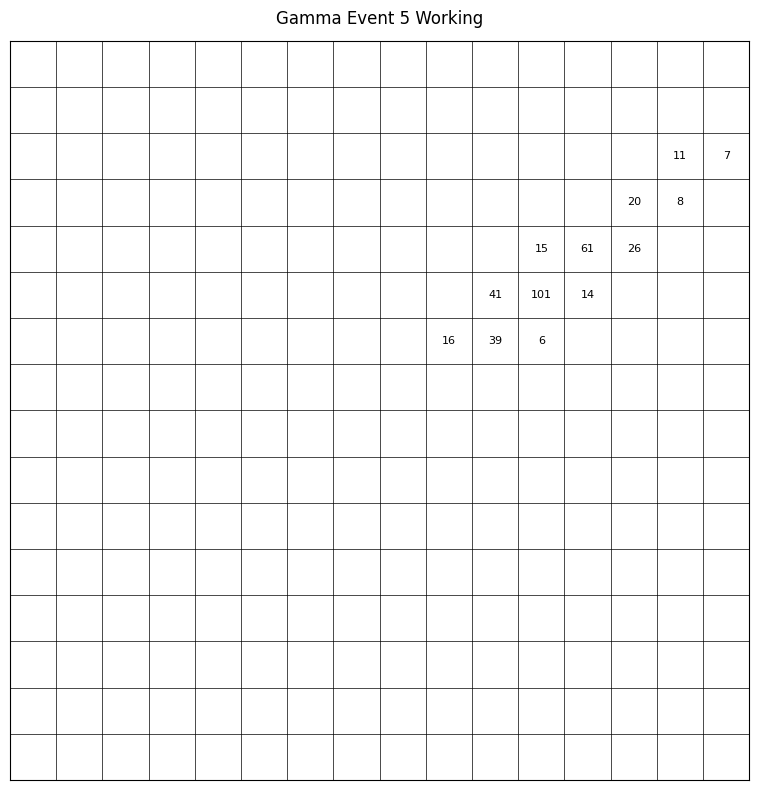

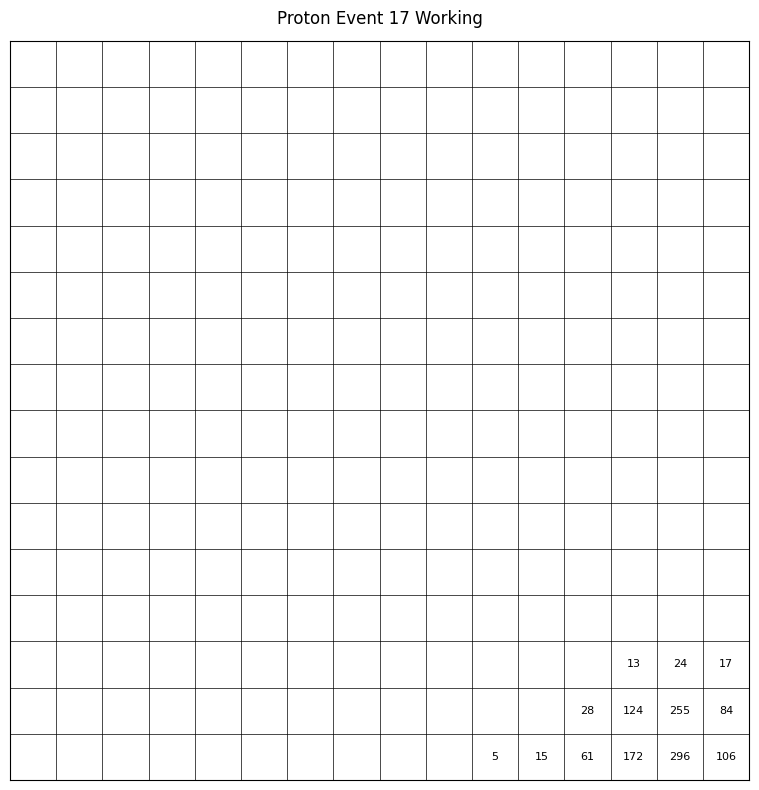

In [9]:
gamma_working = helper.process_event_batch_with_suppression(
    gamma_event_data, gamma_amplitudes, gamma_means, gamma_stds
)

proton_working = helper.process_event_batch_with_suppression(
    proton_event_data, proton_amplitudes, proton_means, proton_stds
)
helper.plot_pixel_matrix(gamma_working[4], 'Gamma Event 5 Working')
helper.plot_pixel_matrix(proton_working[16], 'Proton Event 17 Working')


In [10]:
helper.save_shower_analysis_to_txt(
    events = gamma_working,
    bt_values = gamma_bt_values,
    pt_values = gamma_pt_values,
    output_file= 'gamma_shower_analysis.txt'  
)

/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/helper.py:522: RuntimeWarning: invalid value encountered in scalar divide
  radial_orientation_angle = 90.0 if denom == 0 else np.degrees(np.arctan(abs((orientation_slope - radial_slope) / denom)))
/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/helper.py:521: RuntimeWarning: invalid value encountered in scalar multiply
  denom = 1 + radial_slope * orientation_slope


In [11]:
helper.save_shower_analysis_to_txt(
    events = proton_working,
    bt_values = proton_bt_values,
    pt_values = proton_pt_values,
    output_file= 'proton_shower_analysis.txt'
)

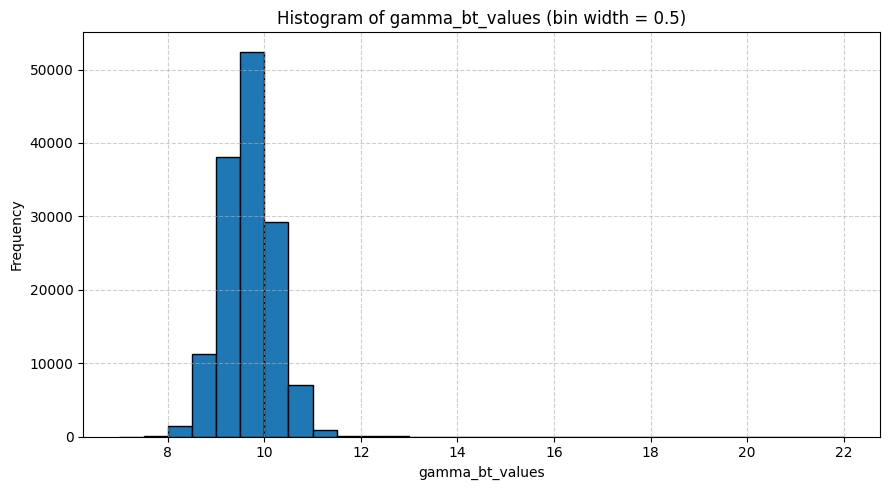

In [11]:
bin_width = 0.5                      # <- new bin width
lo = np.floor(gamma_bt_values.min() / bin_width) * bin_width
hi = np.ceil (gamma_bt_values.max() / bin_width) * bin_width

bins = np.arange(lo, hi + bin_width, bin_width)   # step = 0.5

plt.figure(figsize=(9, 5))
plt.hist(gamma_bt_values, bins=bins, edgecolor='black')
plt.title(f'Histogram of gamma_bt_values (bin width = {bin_width})')
plt.xlabel('gamma_bt_values')
plt.ylabel('Frequency')
plt.grid(ls='--', alpha=.6)
plt.tight_layout()
plt.show()

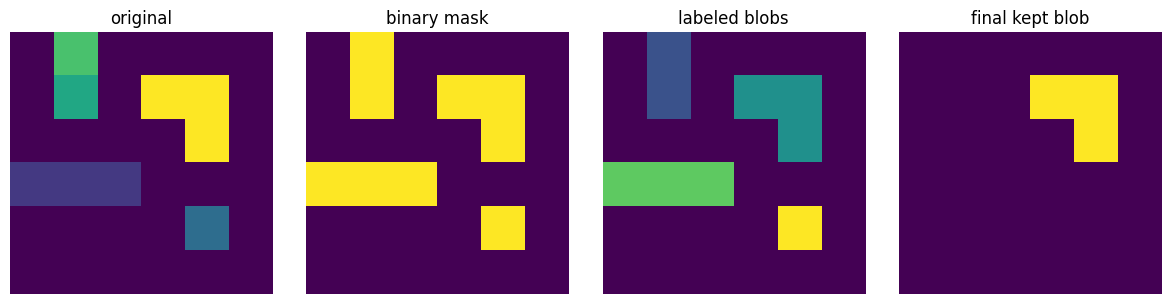

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Synthetic 6×6 “image”
matrix = np.array([
    [0, 30, 0,  0,  0,  0],
    [0, 25, 0, 42, 42, 0],
    [0,  0, 0,  0, 42, 0],
    [7,  7, 7,  0,  0, 0],
    [0,  0, 0,  0, 15, 0],
    [0,  0, 0,  0,  0, 0]
])

def suppress_isolated_pixels_demo(matrix, min_cluster_size=2):
    binary_mask = (matrix > 0).astype(int)

    structure    = np.ones((3, 3), int)
    labeled, _   = label(binary_mask, structure=structure)

    max_pos      = np.unravel_index(np.argmax(matrix), matrix.shape)
    tgt_label    = labeled[max_pos]

    cleaned      = np.zeros_like(matrix)
    if tgt_label and (labeled == tgt_label).sum() >= min_cluster_size:
        cleaned[labeled == tgt_label] = matrix[labeled == tgt_label]

    # --- plot --------------------------------------------------------------
    titles = ['original', 'binary mask', 'labeled blobs', 'final kept blob']
    images = [matrix, binary_mask, labeled, cleaned]

    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    for i, (im, title) in enumerate(zip(images, titles)):
        ax[i].imshow(im, cmap='viridis', vmin=0)
        ax[i].set_title(title)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

suppress_isolated_pixels_demo(matrix)

In [12]:


import numpy as np
import matplotlib.pyplot as plt

def extract_and_plot_distribution(parameter: str,
                                  gamma_file: str = "gamma_shower_analysis.txt",
                                  proton_file: str = "proton_shower_analysis.txt",
                                  bin_range: tuple = None,
                                  bin_count: int = 100,
                                  title: str = None):
    """
    Extract a parameter from gamma and proton files and plot max-normalized frequency distributions.

    Only includes rows where total_active_pixels > 0.
    """

    def extract_parameter(filename: str, parameter: str) -> np.ndarray:
        """
        Extracts a parameter's values from a tab-separated file with a header,
        filtering rows where total_active_pixels > 0 and skipping invalid/missing values.

        Parameters:
            filename (str): Path to the file.
            parameter (str): Column name to extract.

        Returns:
            np.ndarray: Cleaned array of values.
        """
        with open(filename, 'r') as f:
            header = f.readline().strip().split('\t')
            try:
                param_idx = header.index(parameter)
                tap_idx = header.index("total_active_pixels")
            except ValueError as e:
                raise ValueError(f"Missing expected parameter: {e}. Available: {header}")

            values = []
            for line in f:
                if not line.strip():
                    continue
                parts = line.strip().split('\t')
                if len(parts) > max(param_idx, tap_idx):
                    try:
                        total_active_pixels = float(parts[tap_idx])
                        val = float(parts[param_idx])
                        if total_active_pixels > 0 and np.isfinite(val):
                            values.append(val)
                    except ValueError:
                        continue  # Skip malformed rows

        return np.array(values)
    
    # Extract values
    # Extract values
    gamma_vals = extract_parameter(gamma_file, parameter)
    proton_vals = extract_parameter(proton_file, parameter)


    # Determine bins
    if bin_range:
        bins = np.linspace(*bin_range, bin_count)
    else:
        min_val = min(np.min(gamma_vals), np.min(proton_vals))
        max_val = max(np.max(gamma_vals), np.max(proton_vals))
        bins = np.linspace(min_val, max_val, bin_count)

    # Calculate histograms
    # Compute histograms
    # Compute histograms with probability density normalization
    gamma_hist, bins = np.histogram(gamma_vals, bins=bins, density=False)
    gamma_hist = gamma_hist / np.sum(gamma_hist)

    proton_hist, _ = np.histogram(proton_vals, bins=bins, density=False)
    proton_hist = proton_hist / np.sum(proton_hist)

    # Get bin centers for step plot
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Plot as step plots (outlines only, no bars)
    plt.figure(figsize=(10, 6))
    plt.step(bin_centers, gamma_hist, where='mid', label='Gamma', color='blue', linewidth=2)
    plt.step(bin_centers, proton_hist, where='mid', label='Proton', color='orange', linewidth=2)

    plt.xlabel(parameter.replace('_', ' ').title())
    plt.ylabel("Normalized Frequency (Sum = 1)")
    plt.title(title or f"Normalized Frequency of {parameter.replace('_', ' ').title()}: Gamma vs Proton")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #print("Gamma values:", gamma_vals)
    #print("Proton values:", proton_vals)
    #print("Min/Max Gamma:", np.min(gamma_vals), np.max(gamma_vals)) if gamma_vals.size > 0 else print("No gamma data")





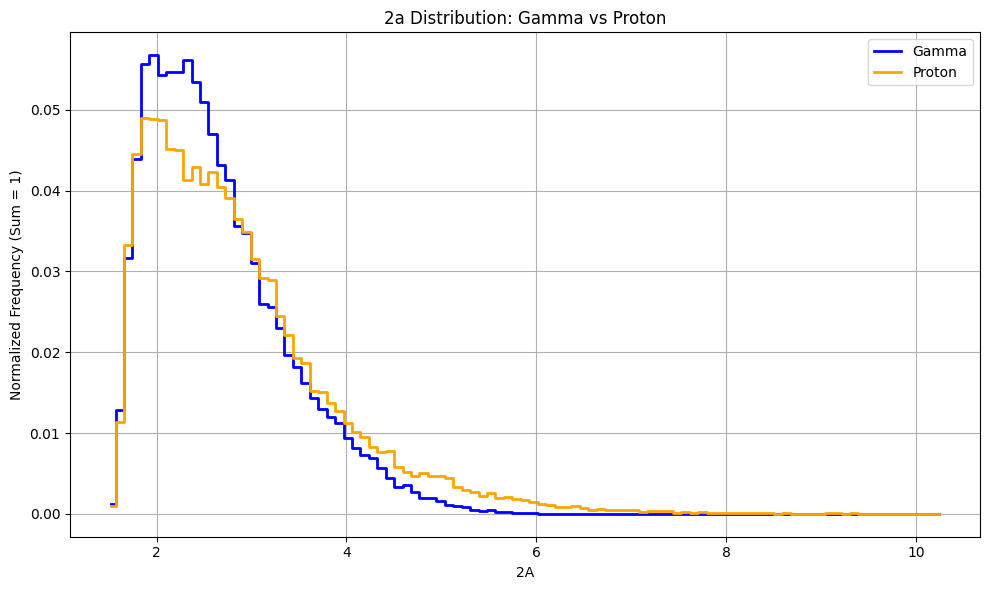

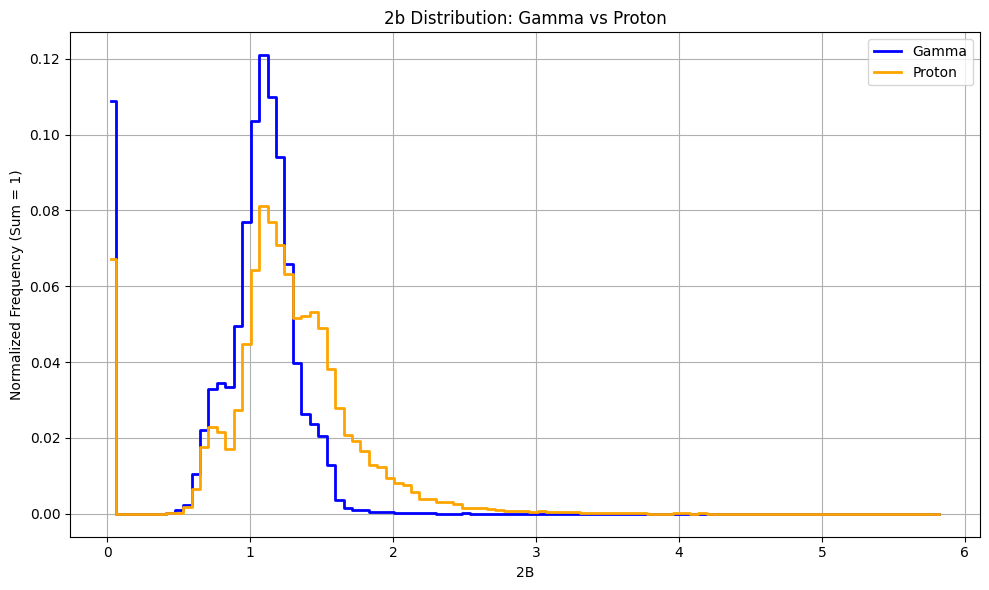

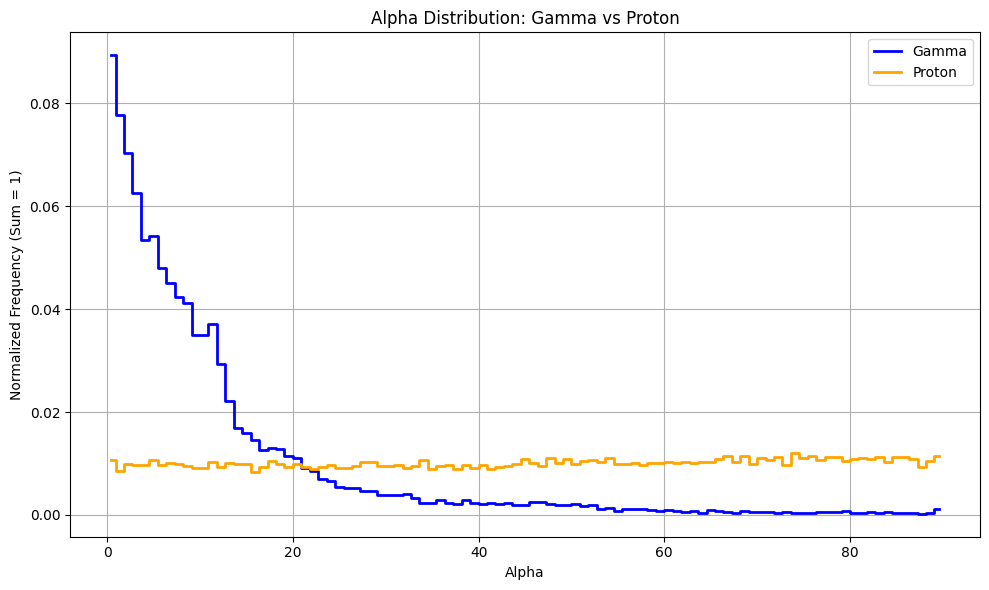

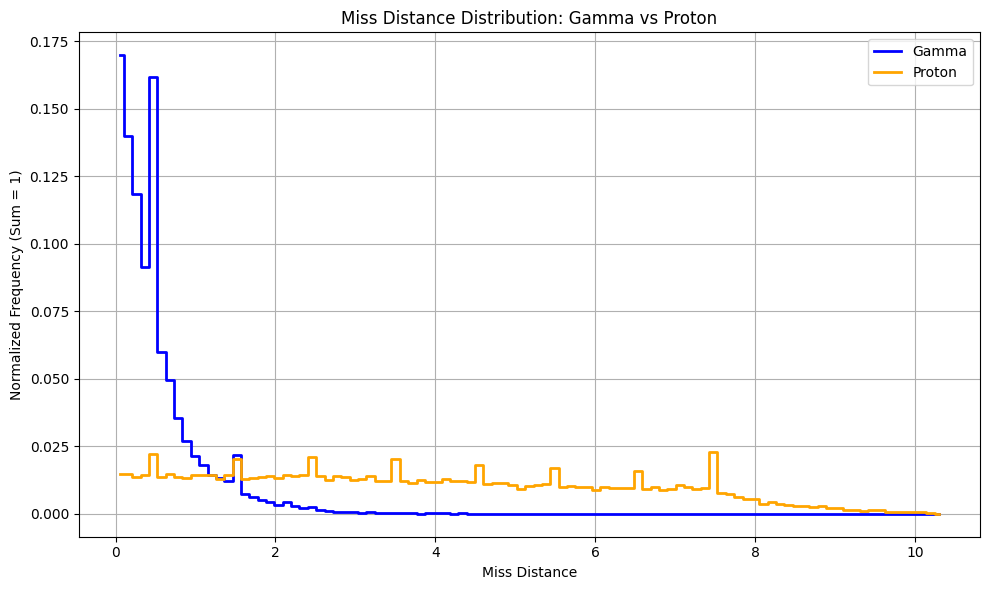

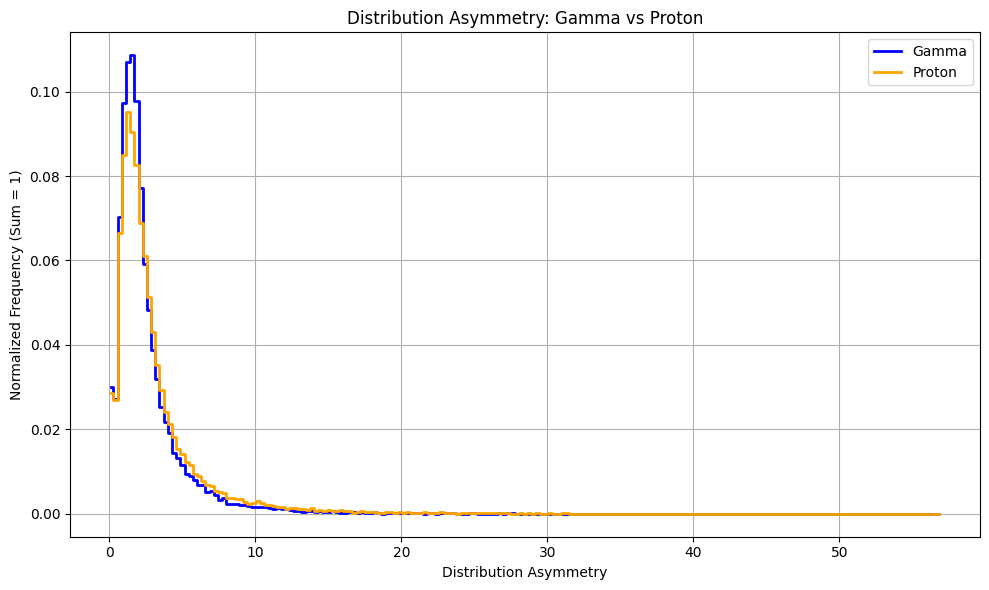

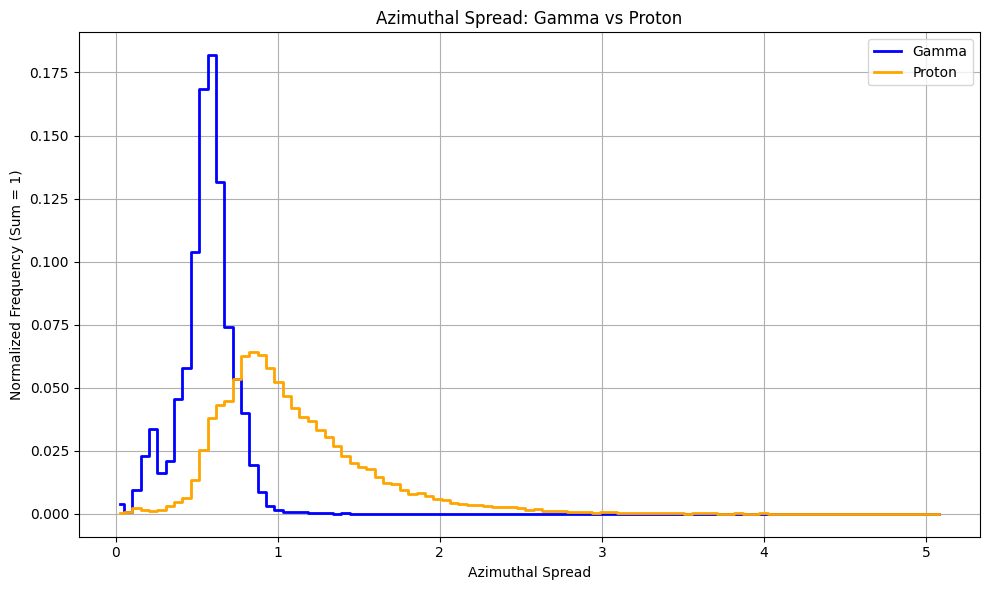

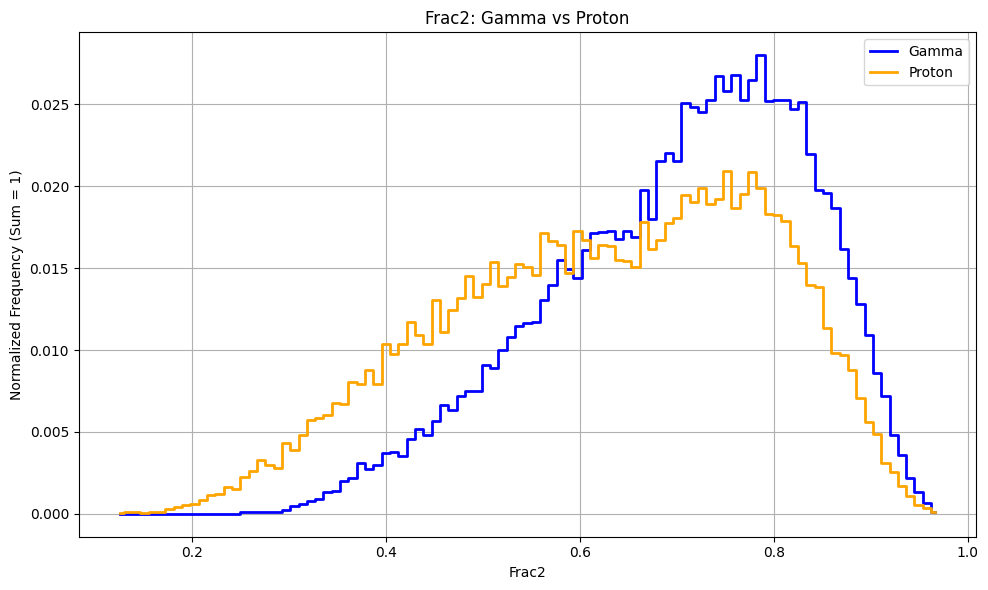

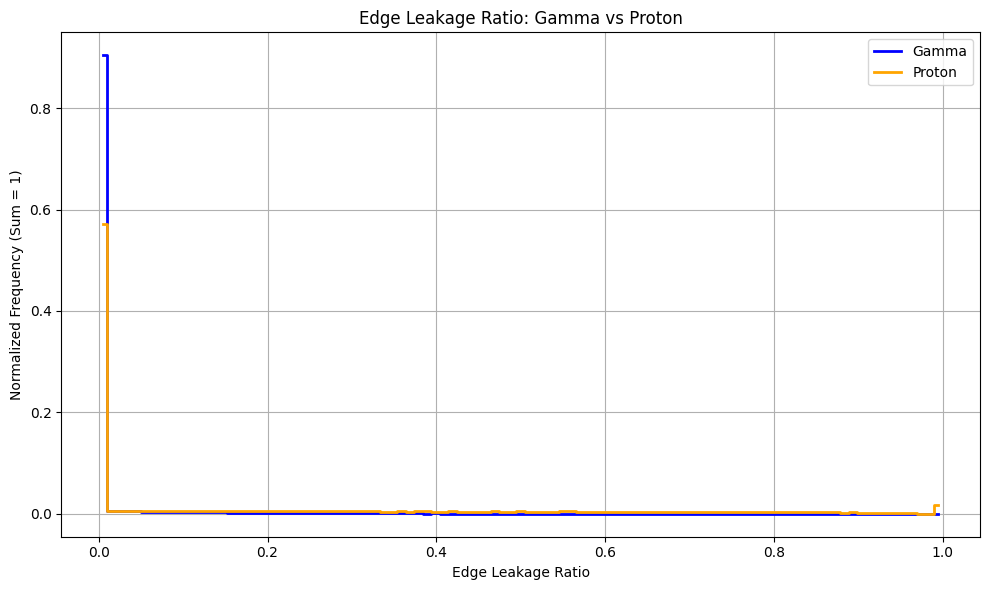

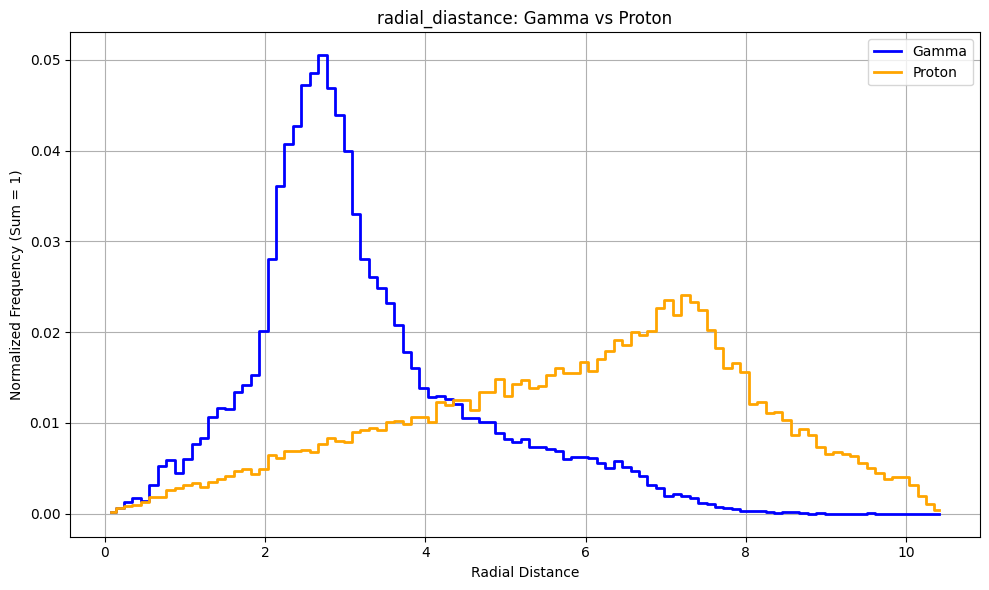

In [13]:
extract_and_plot_distribution(
    gamma_file="gamma_shower_analysis.txt",
    proton_file="proton_shower_analysis.txt",
    parameter="2a",
    title="2a Distribution: Gamma vs Proton"
)
extract_and_plot_distribution(
    gamma_file="gamma_shower_analysis.txt",
    proton_file="proton_shower_analysis.txt",
    parameter="2b",
    title="2b Distribution: Gamma vs Proton"
)
extract_and_plot_distribution(
    gamma_file="gamma_shower_analysis.txt",
    proton_file="proton_shower_analysis.txt",
    parameter="alpha",
    title="Alpha Distribution: Gamma vs Proton"
)
extract_and_plot_distribution(
    parameter="miss_distance",
    title="Miss Distance Distribution: Gamma vs Proton",
)
extract_and_plot_distribution(parameter="distribution_asymmetry",
                              title="Distribution Asymmetry: Gamma vs Proton",
                              bin_count=200)
extract_and_plot_distribution(parameter="azimuthal_spread",
                                title="Azimuthal Spread: Gamma vs Proton")
extract_and_plot_distribution(parameter="frac2",
                                title="Frac2: Gamma vs Proton")
extract_and_plot_distribution(
    parameter="edge_leakage_ratio",
    title="Edge Leakage Ratio: Gamma vs Proton"
)
extract_and_plot_distribution(
    parameter="radial_distance",
    title="radial_diastance: Gamma vs Proton"
)